In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

sns.set()

In this section, we load the RECS (Residential Energy Consumption Survey) dataset and remove columns associated with the "End-use Model" to avoid using derived features from other models.

In [2]:
recs_codebook_df = pd.read_csv('recs2020_codebook.csv', header=1)
print("Codebook loaded successfully.")

recs_df = pd.read_csv('recs2020_data.csv')
print("Data loaded successfully.")

Codebook loaded successfully.
Data loaded successfully.


In [3]:
# Filter for only single-family homes (attached)
single_family_homes = recs_df[(recs_df['TYPEHUQ'] == 2)]

# Function to convert floats to integers and preserve NaN
def convert_to_int(x):
    if isinstance(x, float):
        if np.isnan(x):
            return np.nan  # Preserve NaN
        else:
            return int(x)  # Convert float to integer
    return x

# Apply the conversion to all numeric values
single_family_homes = single_family_homes.applymap(convert_to_int)

# Now, select columns where 'Include' is 'y'
cols_to_keep = recs_codebook_df[recs_codebook_df['Include'] == 'y']['Variable'].tolist()

# Select columns marked as 'outlier' to handle them separately
cols_to_fix = recs_codebook_df[recs_codebook_df['Include'] == 'outlier']['Variable'].tolist()

# Create a subset of the dataframe with selected columns
df_y = single_family_homes[cols_to_keep]
df_f = single_family_homes[cols_to_fix]

print(f"Selected {len(cols_to_keep)} features for analysis.")

Selected 49 features for analysis.


In [4]:
def map_codes_to_descriptions(column, response_codes):
    """ Maps numeric codes to their respective descriptions based on the codebook. """
    mapping = {}
    if isinstance(response_codes, str):
        for item in response_codes.split('\n'):
            parts = item.split(maxsplit=1)  # split by max of 2 to ensure correct parsing
            if len(parts) == 2:  # ensure there are exactly 2 elements: code and description
                code, desc = parts
                try:
                    # Map both float and integer versions of the code
                    mapping[float(code)] = desc.strip()
                    mapping[int(float(code))] = desc.strip()  # Add integer counterpart
                except ValueError:
                    # Skip if the code is non-numeric
                    mapping[code] = desc.strip()
    
    return column.replace(mapping)

# Apply categorical transformations and special case handling
# Cross-check and transform categorical columns with numeric codes
for var in df_y.columns:
    if var in recs_codebook_df['Variable'].values:
        response_codes = recs_codebook_df[recs_codebook_df['Variable'] == var]['Response Codes'].values[0]
        df_y.loc[:, var] = map_codes_to_descriptions(df_y[var], response_codes)


In [5]:
# Ensure df_y and df_f are copies to avoid SettingWithCopyWarning
df_y = single_family_homes[cols_to_keep].copy()
df_f = single_family_homes[cols_to_fix].copy()

# Handle outliers in the 'df_f' dataframe, use .loc to avoid warnings
df_f.loc[:, ['LGTINLED', 'LGTINCFL', 'LGTINCAN']] = df_f[['LGTINLED', 'LGTINCFL', 'LGTINCAN']].replace(0, 5)
df_f[df_f < 0] = np.nan
df_f.replace(99, np.nan, inplace=True)

# Combine the cleaned 'outlier' columns with the main dataframe
subset_df = df_y.join(df_f)
print(f"The dataset now has {subset_df.shape[0]} rows and {subset_df.shape[1]} columns after combining.")


The dataset now has 12319 rows and 117 columns after combining.


In [6]:
# Apply the transformation function to the columns we identified
columns_to_transform = ['LGTOUTNITE', 'LGTOUTLED', 'LGTOUTCFL', 'LGTOUTCAN', 'SMARTMETER', 'INTDATAACC', 'SOLAR', 'WOODTYPE', 'OUTLET', 'EVHOMEAMT', 'KOWNRENT']

# Function to map numeric codes to descriptions based on the codebook
def map_codes_to_descriptions(column, response_codes):
    mapping = {}
    if isinstance(response_codes, str):
        for item in response_codes.split('\n'):
            parts = item.split(maxsplit=1)  # split by max of 2 to ensure correct parsing
            if len(parts) == 2:  # ensure there are exactly 2 elements: code and description
                code, desc = parts
                try:
                    # Map both float and integer versions of the code
                    mapping[float(code)] = desc.strip()
                    mapping[int(float(code))] = desc.strip()  # Add integer counterpart
                except ValueError:
                    # Skip if the code is non-numeric
                    mapping[code] = desc.strip()
    return column.replace(mapping)

# Reapply transformations for the identified columns
for col in columns_to_transform:
    # Check if the column exists in the codebook using 'Variable' column
    if col in recs_codebook_df['Variable'].values:
        # Fetch the response codes for the column
        response_codes = recs_codebook_df[recs_codebook_df['Variable'] == col]['Response Codes'].values[0]
        # Apply the mapping
        subset_df[col] = map_codes_to_descriptions(subset_df[col], response_codes)
    else:
        print(f"Column {col} not found in the codebook.")


In [7]:
subset_df.head()

,DOEID,REGIONC,state_postal,BA_climate,UATYP10,HDD65,CDD65,HDD30YR_PUB,CDD30YR_PUB,KOWNRENT,...,LGTOUTNITE,LGTOUTLED,LGTOUTCFL,LGTOUTCAN,SMARTMETER,INTDATAACC,SOLAR,WOODTYPE,OUTLET,EVHOMEAMT
0,100001,WEST,NM,Mixed-Dry,U,3844,1679,4451,1027,Own,...,3.0,Yes,No,No,No,NaN,No,NaN,Yes,NaN
3,100004,SOUTH,SC,Mixed-Humid,U,2614,1718,3229,1653,Own,...,NaN,NaN,NaN,NaN,Yes,No,No,NaN,Yes,NaN
5,100006,SOUTH,TX,Hot-Humid,U,901,3558,1150,3588,Rent,...,6.0,Yes,No,No,Yes,No,No,Wood logs or split wood,Yes,NaN
6,100007,SOUTH,OK,Mixed-Humid,U,3148,2128,3564,2043,Rent,...,2.0,Yes,No,No,Yes,No,No,NaN,Yes,NaN
10,100011,WEST,CA,Hot-Dry,U,1467,2108,1944,1747,Own,...,3.0,Yes,No,No,Yes,No,Yes,NaN,Yes,NaN


In [8]:
# Calculate the number of non-missing values in each column
number_values = subset_df.count()

# Identify columns with more than 25% missing data
threshold = 0.75 * len(subset_df)
cols_to_drop = [col for col in subset_df.columns if subset_df[col].count() < threshold]

# Drop columns with too many missing values
subset_df = subset_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns due to excessive missing data.")

# Recalculate the number of missing values
missing_percentage = subset_df.isnull().mean() * 100
print(f"Remaining missing data percentage: {missing_percentage.mean():.2f}%")

# Check the number of features with missing data
num_missing_cols = subset_df.columns[subset_df.isnull().any()].tolist()
print(f"There are {len(num_missing_cols)} features with missing data remaining.")


Dropped 36 columns due to excessive missing data.
Remaining missing data percentage: 1.52%
There are 18 features with missing data remaining.


In [9]:
# Separate numerical and categorical columns
numerical_cols = subset_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = subset_df.select_dtypes(include=['object']).columns.tolist()

# Impute numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
subset_df[numerical_cols] = num_imputer.fit_transform(subset_df[numerical_cols])

# Impute categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
subset_df[categorical_cols] = cat_imputer.fit_transform(subset_df[categorical_cols])

print("Imputation completed for missing values.")


Imputation completed for missing values.


In [10]:
# Normalize numerical columns using Min-Max scaling
scaler = MinMaxScaler()
subset_df[numerical_cols] = scaler.fit_transform(subset_df[numerical_cols])

print("Normalization of numerical data completed.")

Normalization of numerical data completed.


In [11]:
# Apply one-hot encoding to categorical columns using pandas get_dummies
subset_df = pd.get_dummies(subset_df, columns=categorical_cols, drop_first=True)

print(f"The dataset now has {subset_df.shape[1]} columns after one-hot encoding.")


The dataset now has 140 columns after one-hot encoding.


In [12]:
# Perform PCA to capture 90% of the variance
pca = PCA(n_components=0.90, random_state=42)
pca_result = pca.fit_transform(subset_df)

print(f"PCA reduced the dataset to {pca_result.shape[1]} principal components.")


PCA reduced the dataset to 60 principal components.


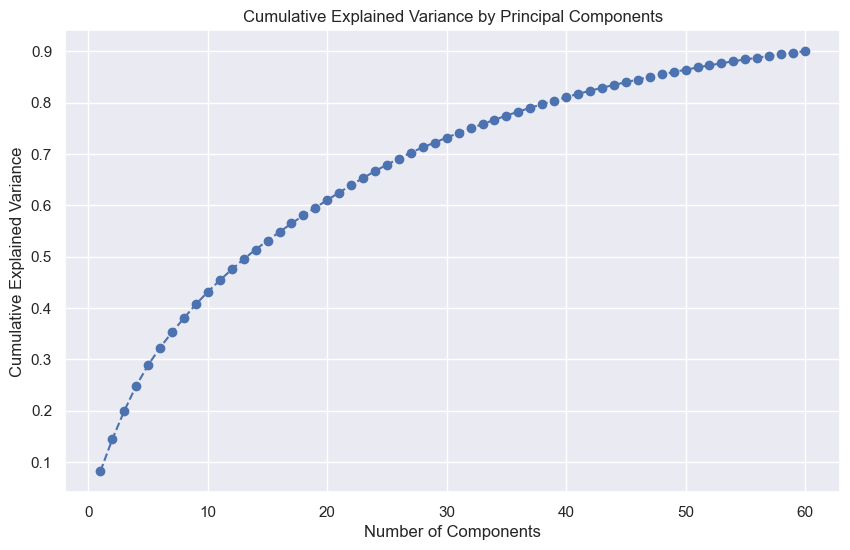

Number of components explaining at least 90% variance: 60


In [13]:
# Plot cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the number of components that explain at least 90% of the variance
components_90_variance = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components explaining at least 90% variance: {components_90_variance}")

pca_90 = PCA(n_components=components_90_variance)
pca_90_result = pca_90.fit_transform(subset_df)

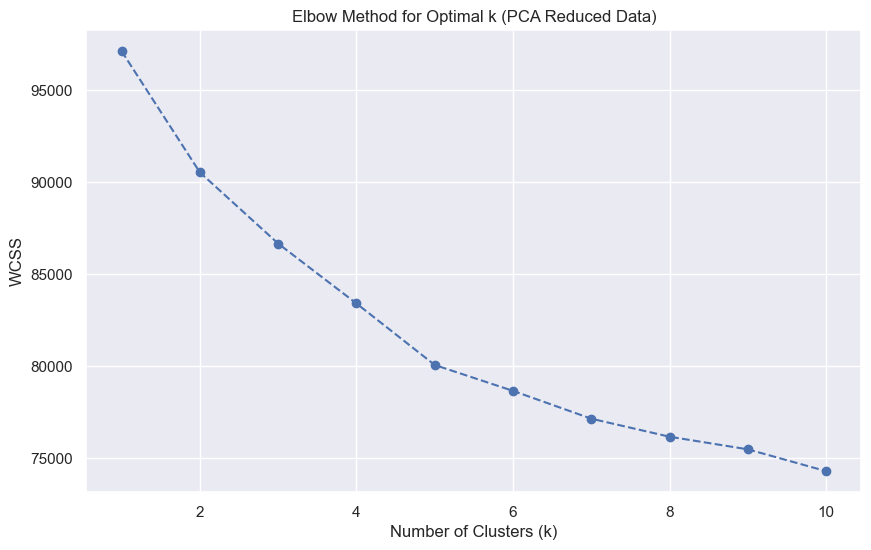

In [14]:
# Calculate WCSS (within-cluster sum of squares) for different values of k
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_result)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA Reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

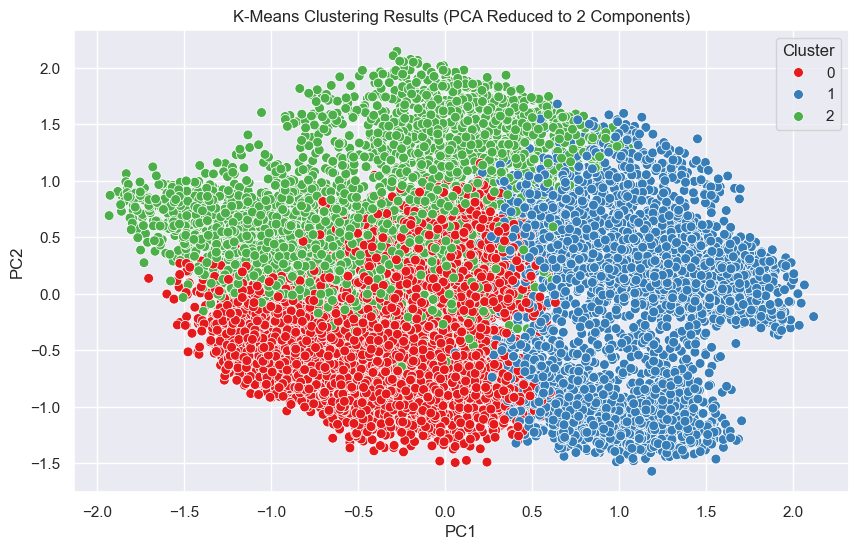

In [15]:
# Perform K-means clustering with the chosen k
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_90_result)

# Reduce to 2 components for visualization
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=50)
plt.title('K-Means Clustering Results (PCA Reduced to 2 Components)')
plt.show()

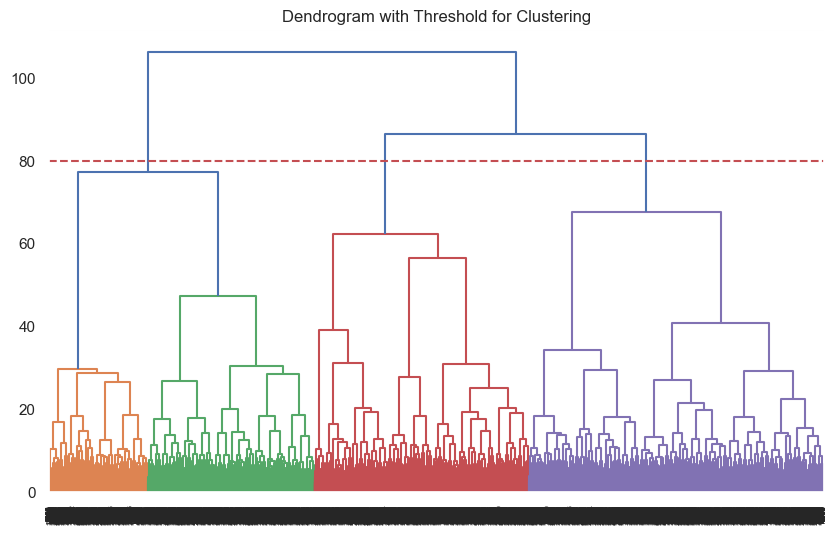

In [16]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Plot the Dendrogram with a threshold
plt.figure(figsize=(10, 6))
plt.title("Dendrogram with Threshold for Clustering")
dend = shc.dendrogram(shc.linkage(pca_90_result, method='ward'))
plt.axhline(y=80, color='r', linestyle='--')  # Adjust the y-value to focus on higher levels of clustering
plt.show()

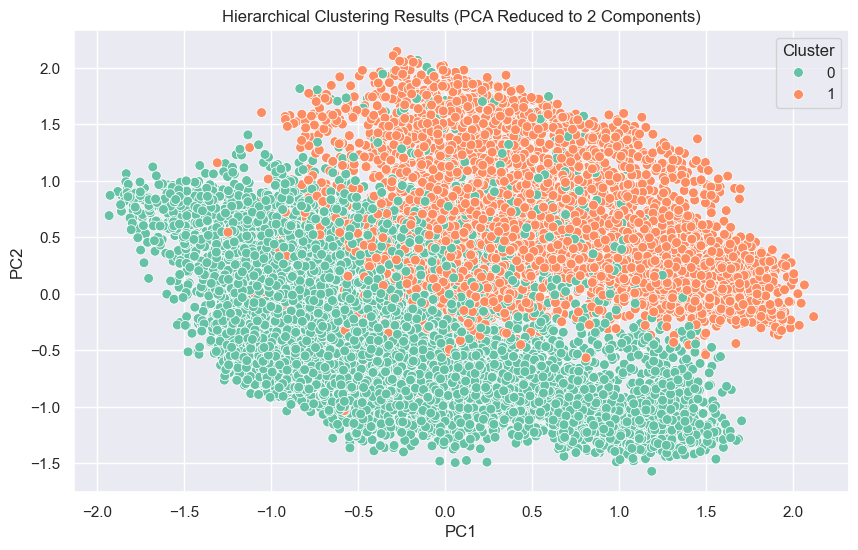

In [17]:
# Perform Hierarchical Clustering with 2 clusters
hierarchical = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_90_result)  

# Visualize the clusters using the first two PCA components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = hierarchical_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=50)
plt.title('Hierarchical Clustering Results (PCA Reduced to 2 Components)')
plt.show()

We begin by generating summary statistics for each cluster. This will give us an understanding of the average values, medians, and ranges of key features for each cluster.

In [18]:
# Generate summary statistics for each cluster (numerical columns only)
def get_cluster_summary(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select only numerical columns
    numeric_data = data.select_dtypes(include=[np.number])
    summary = numeric_data.groupby('Cluster').agg(['mean', 'median', 'min', 'max'])
    return summary

# Apply to K-means clusters
kmeans_summary = get_cluster_summary(subset_df.copy(), kmeans_labels)
print(kmeans_summary)

# Apply to hierarchical clusters
hierarchical_summary = get_cluster_summary(subset_df.copy(), hierarchical_labels)
print(hierarchical_summary)

            DOEID                                   HDD65                 \
             mean    median       min       max      mean    median  min   
Cluster                                                                    
0        0.499810  0.502028  0.000162  0.999459  0.306101  0.302249  0.0   
1        0.504386  0.509922  0.000000  1.000000  0.109022  0.097797  0.0   
2        0.505906  0.506353  0.000703  0.999838  0.313064  0.309613  0.0   

                      CDD65            ... LGTINLED       LGTINCFL         \
              max      mean    median  ...      min  max      mean median   
Cluster                                ...                                  
0        0.810735  0.176352  0.171485  ...      0.0  1.0  0.767373   0.75   
1        0.615774  0.494990  0.470184  ...      0.0  1.0  0.756327   0.75   
2        1.000000  0.181390  0.161185  ...      0.0  1.0  0.776328   0.75   

                   LGTINCAN                   
         min  max      mean media